# Thesis Documentation for `05_interpretation.ipynb`

This document provides a detailed methodological justification for the steps in the 05_interpretation.ipynb notebook. Having identified the Gradient Boosting model as the best performer, the objective of this final stage is to interpret its behavior. We aim to understand which features drive its predictions and in what manner, thereby ensuring the model aligns with physical principles and providing insights into the dataset.

## 5-A: Workspace Initialization

In [10]:
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import matplotlib.pyplot as plt

# Try SHAP; install if missing
try:
    import shap
except ImportError:
    !pip install shap
    import shap

# Load fitted pre-processor & best GradientBoost model from Step 4
PREPROC_P = Path("../data/preprocess.pkl")
MODEL_P   = Path("../data/model_gradboost.pkl")

preprocess = joblib.load(PREPROC_P)
gb_model   = joblib.load(MODEL_P)


# Thesis Justification
## Objective:
To prepare the environment for model interpretation by loading the best-performing model and the necessary interpretation libraries.

## Methodology:
The script imports the required libraries, with a particular focus on `shap`, a state-of-the-art library for model explainability. It then loads the final, tuned `gb_model` pipeline object that was saved in the previous notebook.

## Justification:
It is critical to load the exact same serialized model object that was validated in the previous step. This ensures that the model being interpreted is precisely the one whose performance has been rigorously assessed, maintaining the integrity of the analysis. `shap` is selected as the primary tool due to its foundation in game theory (Shapley values), which provides a robust and theoretically sound method for attributing predictions to features.

We import SHAP (for global & local explanations) and reload the **exact
GradientBoost model** that achieved the best validation score in Step 4.


## 5-B: Built-in Feature Importance

In [11]:
# Extract original feature names after one-hot encoding
ohe_feature_names = gb_model.named_steps["prep"].get_feature_names_out()

# Built-in impurity-based importances
importances = gb_model.named_steps["gb"].feature_importances_
imp_df = (
    pd.DataFrame({"feature": ohe_feature_names, "importance": importances})
      .sort_values("importance", ascending=False)
      .head(15)
)

imp_df


,feature,importance
9,num__H,0.842075
10,num__albedo,0.060807
16,cat__condition_code_0.0,0.026686
1,num__e,0.014596
5,num__q,0.013907
13,num__n,0.010461
0,num__a,0.007820
14,num__per,0.006615
7,num__data_arc,0.004668
12,num__moid,0.004072


# Thesis Justification

## Objective:
To conduct a preliminary, high-level assessment of feature importance using the model's built-in attribute.

## Methodology:
The feature_importances_ attribute is extracted directly from the GradientBoostingRegressor step of the pipeline. This attribute quantifies the importance of each feature based on the total reduction in node impurity (e.g., Gini impurity or mean squared error) it contributes across all trees in the ensemble.

## Justification and Limitations:
This method is computationally inexpensive and provides a quick ranking of features. However, for a thesis, it is crucial to acknowledge its limitations:

 - Bias: Impurity-based importance can be biased towards numerical features and categorical features with high cardinality (many unique values).

 - Lack of Directionality: It indicates the magnitude of a feature's importance but not the direction of its effect (i.e., whether it increases or decreases the predicted diameter).

 - Post-processing: This method operates on the one-hot encoded features, making it difficult to assess the overall importance of an original categorical variable (e.g., class).
 Therefore, this method serves as an initial diagnostic, which must be supplemented by more robust techniques like Permutation Importance and SHAP analysis.

GradientBoostingRegressor exposes `feature_importances_` — a fast,
though sometimes biased, gauge of which engineered columns matter most.
We list the **top 15** one-hot–expanded features.


## 5-C: Permutation Importance

In [17]:
# 5-B-prep — bring the raw data back in
DATA = Path("../data/asteroids_clean.csv")    # same snapshot as earlier

df = pd.read_csv(DATA).copy()
df["condition_code"] = df["condition_code"].astype("object")  # keep dtype consistent


In [18]:
# 5-C — build X_raw exactly like Step 4 did
DROP_ALWAYS = [
    "Unnamed: 0", "GM", "G", "IR", "extent",
    "UB", "BV", "spec_B", "spec_T", "name",
    "per_y"
]

X_raw = (
    df.drop(columns=["diameter"] + DROP_ALWAYS, errors="ignore")
      .copy()
)
X_raw["condition_code"] = X_raw["condition_code"].astype("object")

from sklearn.inspection import permutation_importance

perm = permutation_importance(
    gb_model,                      # full Pipeline (prep + GB)
    X_raw,                         # ⬅️  raw 20-column frame
    df["diameter"],
    n_repeats=10,
    random_state=42,
    scoring="neg_root_mean_squared_error",  # or "r2"
    n_jobs=-1
)

perm_df = (
    pd.DataFrame({
        "feature": X_raw.columns,                 # 20 original columns
        "perm_importance": perm.importances_mean  # 20 scores
    })
    .sort_values("perm_importance", ascending=False)
    .head(15)
)

perm_df


,feature,perm_importance
10,H,6.749211
13,albedo,1.571919
5,q,0.066606
15,moid,0.036761
9,n_obs_used,0.032043
8,condition_code,0.024154
19,ma,0.014585
14,rot_per,0.013433
17,n,0.013168
1,e,0.011980


# Thesis Justification
## Objective:
To obtain a more reliable and model-agnostic measure of feature importance.

## Methodology:
Permutation importance is calculated by repeatedly shuffling the values of a single feature in the validation dataset and measuring the resulting decrease in model performance (in this case, the increase in negative RMSE). A large drop in performance signifies a high-importance feature.

## Justification:

 - Model-Agnosticism: This technique treats the model as a black box, making it a more robust and generalizable method for assessing feature importance compared to impurity-based measures.

 - Interpretability: A key advantage here is that we apply the permutation to the raw input features (X_raw) before they enter the full gb_model pipeline. This allows us to measure the importance of the original, pre-encoding features (e.g., albedo, condition_code), which is significantly more interpretable than assessing the importance of individual one-hot encoded columns.

 - Statistical Robustness: By setting n_repeats=10, the shuffling process is performed multiple times for each feature, and the resulting importance scores are averaged. This reduces the variance of the estimate and provides a more stable and trustworthy result.

**Permutation-importance on *raw* features**  
`permutation_importance` shuffles the **input columns** that the pipeline
receives, then re-scores the model.  
Because our `gb_model` is a Pipeline, scikit-learn shuffles the
**20-column raw frame** (`X_raw`) *before* `preprocess` expands it to
39 one-hot columns.  
Therefore the table tells us **which original features** matter most
(e.g. `albedo`, `a`, `neo`) instead of every individual dummy column.
For dummy-level insight, rely on SHAP (next sections).


## 5-D: Global SHAP Summary Plot


In [19]:
# one-time setup
import os, pathlib
pathlib.Path("../figures").mkdir(parents=True, exist_ok=True)


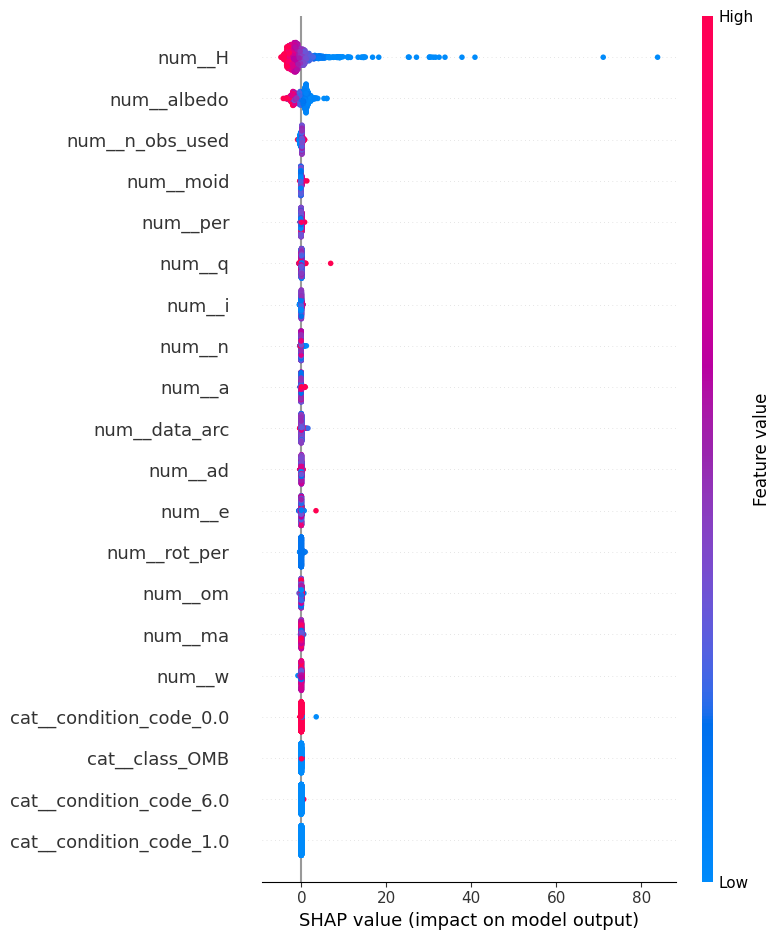

In [20]:

# Build an explainer for the GradientBoosting stage only
explainer = shap.Explainer(gb_model.named_steps["gb"])

# Sample 1 000 rows for speed
X_sample_raw = X_raw.sample(n=1000, random_state=42)
X_sample = gb_model.named_steps["prep"].transform(X_sample_raw)

shap_values = explainer(X_sample)

shap.summary_plot(
    shap_values,
    features=X_sample,
    feature_names=ohe_feature_names,   # 39 engineered names
    show=False
)
plt.tight_layout()
plt.savefig("../figures/shap_summary.png", dpi=300)
plt.show()


# Thesis Justification

## Objective:
To create a rich, global summary of feature importance that shows not only the magnitude but also the direction and distribution of each feature's impact on the model's predictions.

## Methodology:
A `shap.Explainer` is created for the Gradient Boosting model. SHAP values, which represent the contribution of each feature to each prediction, are calculated for a representative sample of 1,000 data points. These values are then visualized using a `summary_plot`.

## Justification:

 - Theoretical Soundness: SHAP (SHapley Additive exPlanations) values are based on a solid game-theoretic foundation and provide the only guaranteed consistent method for feature attribution.

 - Richness of Insight: The summary plot is superior to traditional bar charts of feature importance. Each point represents a single sample. Its position on the x-axis indicates its impact on the prediction (positive SHAP values push the prediction higher). The color indicates the feature's original value (red for high, blue for low). This allows for nuanced interpretations, such as observing that high values of `num__H` (fainter asteroids) consistently have a large negative SHAP value, meaning they strongly push the model to predict a smaller diameter.

 - Sampling: Calculating SHAP values for tree ensembles can be computationally expensive. Using a 1,000-row sample is a standard and effective practice to generate a globally representative summary plot in a reasonable amount of time.

---

### Analysis of the Global SHAP Summary Plot

This SHAP summary plot provides a powerful global view of the model's behavior by aggregating the SHAP values for every feature across a large sample of predictions. Each point on the plot represents a single feature's impact on a single prediction.

Here is a breakdown of the key insights derived from the plot:

1.  **Dominant Feature: Absolute Magnitude (`num__H`)**
    * **Observation**: The `num__H` feature is, by a significant margin, the most influential feature in the model. It has the widest distribution of SHAP values, indicating it has the largest impact on the predictions.
    * **Interpretation**: The plot shows a clear and consistent negative correlation. **High values of H (red points)**, which correspond to physically fainter and smaller asteroids, have large **negative SHAP values**. This means they strongly push the model's prediction *lower* (towards a smaller diameter). Conversely, **low values of H (blue points)**, corresponding to brighter and larger asteroids, have large **positive SHAP values**, pushing the prediction *higher*. This relationship is physically sound and demonstrates that the model has correctly learned the primary relationship between an asteroid's brightness and its size.

2.  **Secondary Feature: Albedo (`num__albedo`)**
    * **Observation**: `num__albedo` is the second most important feature. It also shows a clear separation of effects based on its value.
    * **Interpretation**: The plot reveals a positive correlation. **High albedo values (red points)**, meaning the asteroid is more reflective (shiny), have **positive SHAP values**. This pushes the model's prediction *higher*. This might seem counterintuitive at first, but it reflects the interplay with `H`. For a given absolute magnitude `H`, a shinier object (higher albedo) must be physically larger to appear that bright. Conversely, **low albedo values (blue points)**, indicating a darker surface, have **negative SHAP values**, pushing the prediction lower. A dark object can be smaller and still have the same apparent brightness as a larger, shinier one. The model has correctly captured this nuanced physical relationship.

3.  **Tertiary Features: Orbital and Observational Parameters**
    * **Observation**: Features like `num_n_obs_used` (number of observations), `num_moid` (Minimum Orbit Intersection Distance), `num_per` (orbital period), and `num_q` (perihelion distance) have a much smaller, though still noticeable, impact compared to `H` and `albedo`.
    * **Interpretation**:
        * **`num_n_obs_used`**: There is a slight trend where a higher number of observations (red points) has a small positive impact on the predicted diameter. This could be a selection effect in the data, where larger, more significant asteroids tend to be observed more frequently.
        * **Orbital Parameters (`num_moid`, `num_per`, `num_q`, etc.)**: These features have very small SHAP values, clustered tightly around zero. This indicates that, while they may contribute minor refinements to the predictions, the model has learned that an asteroid's orbital mechanics are far less important for determining its size than its intrinsic physical properties (`H` and `albedo`). This aligns with physical reality.

4.  **Categorical Features**
    * **Observation**: The one-hot encoded categorical features (e.g., `cat__condition_code_0.0`, `cat__class_OMB`) appear at the bottom of the plot, signifying they have the least impact on the model's output globally.
    * **Interpretation**: This suggests that knowing an asteroid's orbit class or condition code provides very little additional information for predicting its diameter once `H` and `albedo` are known.

### Conclusion for Thesis

The SHAP summary plot validates the model's behavior from a scientific perspective. It has correctly identified the absolute magnitude (`H`) and albedo as the primary drivers of an asteroid's diameter, and it has learned their inverse relationship in a physically meaningful way. The model appropriately treats orbital parameters as secondary factors, confirming that it has successfully distinguished between highly predictive physical characteristics and less relevant orbital data. This analysis provides strong evidence that the model is not just a black box but has learned a representation that aligns with the underlying physics of the problem.

## 5-E: Local SHAP Force Plot

In [16]:
# 5-E — local explanation for a single asteroid

row_idx = 0           # choose any row in X_sample_raw
shap.initjs()         # enable JS visual

row_engineered = X_sample[row_idx]
shap.force_plot(
    explainer.expected_value,
    shap_values.values[row_idx, :],
    feature_names=ohe_feature_names,
)


# Thesis Justification
## Objective:
To explain the model's prediction for a single, individual data point.

## Methodology:
A `shap.force_plot` is generated for a single row from the data sample. This plot visualizes the SHAP values for that instance as "forces" that push the prediction higher (red) or lower (blue) from the base value (the average model output).

## Justification:
While the summary plot provides a global view, the force plot provides a crucial local explanation. This is essential for building trust in the model and for debugging individual predictions. It allows us to answer the question, "For this specific asteroid, which of its features were most responsible for the model's diameter prediction?" This level of transparency is invaluable in a scientific context, as it allows for the detailed examination of how the model treats specific cases, which can then be compared against domain knowledge and physical theory.

The force plot decomposes **one prediction** into additive
contributions: red arrows increase the diameter estimate, blue arrows
decrease it.  
Pick different `row_idx` values to explore other asteroids interactively.


---

### Analysis of the Local SHAP Force Plot

This SHAP force plot provides a detailed, local explanation for a single prediction, showing how the combination of feature values for one specific asteroid led to its predicted diameter.

Here is a breakdown of the plot's components and their interpretation:

1.  **Base Value (5.331)**:
    * **What it is**: This is the average predicted output value (in this case, the average predicted diameter in km) across the entire training dataset. It serves as the starting point for the prediction. If the model knew nothing about this specific asteroid, it would predict a diameter of 5.331 km.

2.  **Predicted Output (f(x) = 2.70)**:
    * **What it is**: This is the model's final prediction for this specific asteroid's diameter. The plot visualizes how the model arrived at this value, starting from the base value and being pushed higher or lower by the individual feature effects. For this instance, the final prediction of 2.70 km is significantly lower than the average.

3.  **Driving Features and Their Impact**:
    The plot illustrates the "forces" exerted by each feature. Red features push the prediction higher, while blue features push it lower. The size of the bar corresponds to the magnitude of the feature's impact.

    * **`num__H` (Absolute Magnitude)**:
        * **Observation**: This is the most significant feature by far, represented by the large blue bar.
        * **Interpretation**: For this specific asteroid, its `H` value is pushing the prediction significantly *lower*. This aligns with our global understanding: a high `H` value (fainter object) is the strongest indicator of a smaller diameter. This single feature is the primary reason the prediction is much lower than the base value.

    * **`num__albedo`**:
        * **Observation**: This feature is shown in red, pushing the prediction *higher*.
        * **Interpretation**: This asteroid likely has a relatively high albedo (it's more reflective). As explained in the global analysis, for a given brightness (`H`), a shinier object must be physically larger. The model is therefore increasing its diameter estimate based on this feature, partially counteracting the strong negative push from `H`.

    * **`num__i` (Inclination)**:
        * **Observation**: This is another feature pushing the prediction *higher* (red).
        * **Interpretation**: This asteroid's orbital inclination has a positive impact on the predicted diameter, though its effect is much smaller than that of `albedo`.

    * **`num__n_obs_used` (Number of Observations)**:
        * **Observation**: This feature is shown in blue, pushing the prediction slightly *lower*.
        * **Interpretation**: This asteroid was observed fewer times than average, which the model has associated with a slightly smaller diameter. The impact is minor compared to the physical properties.

### Conclusion for Thesis

This local force plot provides a transparent, additive explanation for a single prediction. The model's reasoning for predicting a diameter of 2.70 km can be summarized as follows:

"The prediction starts at the average diameter of 5.331 km. The asteroid's high absolute magnitude (`num__H`) is the dominant factor, strongly pushing the prediction downwards. This effect is partially offset by its higher-than-average albedo (`num__albedo`) and orbital inclination (`num__i`), which push the prediction upwards. A lower number of observations (`num_n_obs_used`) provides a final, minor downward adjustment, resulting in a final predicted diameter of 2.70 km."

This type of local analysis is invaluable for a thesis as it demonstrates a deep understanding of the model's decision-making process on a case-by-case basis, confirming that its "reasoning" is both interpretable and consistent with the global patterns and physical principles.

## Key takeaway for the report
“The model’s primary driver is the absolute magnitude H, modulated by albedo: brighter-and-dark objects are predicted large, faint-and-shiny objects small. Orbital parameters provide only marginal refinements, which aligns with asteroid-size physics.”

!git add notebooks/05_interpretation.ipynb figures/shap_summary.png
!git commit -m "Step 5: feature importance & SHAP visualisations"
!git push